In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Structure import *
from Utils import *
import scipy.optimize as scopt
import time

In [2]:
def boundary_residual_circle(interior_offsets_vector):
    global width 
    global height 
    global target_phi 
    global structure
    global boundary_points
    global corners
    global boundary_offsets
    global dual_bound_inds
    global reduced_dual_bound_inds
    global boundary_points_vector
    
    # Reshape flattened offsets to 2D grid: (width*height,) -> (height, width)
    interior_offsets = np.reshape(interior_offsets_vector, (height, width))
    
    # update the pattern using the linear inverse design method with the input offset
    structure.linear_inverse_design(boundary_points_vector, corners, interior_offsets, boundary_offsets)
    structure.make_hinge_contact_points()

    # get the second contracted state
    deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
    
    # assess the circularity using sum( (r-r_mean)^2 )
    distance_from_center = np.sqrt(
        np.square(
            np.array(deployed_points[reduced_dual_bound_inds,0]-np.mean(deployed_points[reduced_dual_bound_inds,0]))
            ) + 
        np.square(
                np.array(deployed_points[reduced_dual_bound_inds,1]-np.mean(deployed_points[reduced_dual_bound_inds,1]))
            )
        )
    residuals = distance_from_center - np.mean(distance_from_center)
    
    # (Alternative way) assess the circularity using (L^2/(4*pi*A) - 1)^2
    # reduced_dual_bound_inds_shifted = reduced_dual_bound_inds[1:]
    # reduced_dual_bound_inds_shifted.append(reduced_dual_bound_inds[0])
    # edgelengths = np.sqrt(np.square(np.array(deployed_points[reduced_dual_bound_inds,0]-deployed_points[reduced_dual_bound_inds_shifted,0])) + np.square(np.array(deployed_points[reduced_dual_bound_inds,1]-deployed_points[reduced_dual_bound_inds_shifted,1])))
    # L = np.sum(edgelengths)
    # pgon = geom.Polygon(zip(deployed_points[reduced_dual_bound_inds,0], deployed_points[reduced_dual_bound_inds,1]))
    # A = pgon.area
    # residuals = L**2/(4*np.pi*A) - 1
    
    return residuals

In [3]:
# set the pattern size
width = 9
height = 9

# create a square kirigami structure and get the required information for the optimization
structure = MatrixStructure(num_linkage_rows=height, num_linkage_cols=width)
bound_linkage_inds = [structure.get_boundary_linkages(i) for i in range(4)]
bound_directions = np.array([[-1.0, 0.0], [0.0, -1.0], [1.0, 0.0], [0.0, 1.0]])
boundary_points = []
corners = []
for i, bound in enumerate(bound_linkage_inds):
    local_boundary_points = []
    for j, linkage_ind in enumerate(bound):
        p = structure.is_linkage_parallel_to_boundary(linkage_ind[0], linkage_ind[1], i)
        if j == 0:
            corner = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            if not p:
                corner += bound_directions[(i-1)%4]
            corners.append(corner)
        if not p:
            point = np.array([linkage_ind[1], -linkage_ind[0]]) + bound_directions[i]
            local_boundary_points.append(point)
    boundary_points.append(np.vstack(local_boundary_points))
corners = np.vstack(corners)
boundary_offsets = [[0.0]*height, [0.0]*width, [0.0]*height, [0.0]*width]
boundary_points_vector = np.vstack(boundary_points)

In [4]:
interior_offsets_initial = np.power(10, np.random.rand(height,width) * 2 - 1) - 1
# create random offsets within (-0.9, 0.9)
# interior_offsets = np.random.rand(height, width) * 1.8 - 0.9

# get the resulting random kirigami pattern using the linear inverse design method
structure.linear_inverse_design(np.vstack(boundary_points), corners, interior_offsets_initial, boundary_offsets)

structure.make_hinge_contact_points()
deployed_points, deployed_hinge_contact_points = structure.layout(phi=0.0) 
dual_bound_inds = []
for bound_ind in range(4):
    dual_bound_inds.extend(structure.get_dual_boundary_node_inds(bound_ind))
reduced_dual_bound_inds = []
for i, ind in enumerate(dual_bound_inds):    
    next_i = (i+1) % len(dual_bound_inds)    
    next_ind = dual_bound_inds[next_i]    
    if norm(deployed_points[ind] - deployed_points[next_ind]) > 1e-10:
        reduced_dual_bound_inds.append(ind)


Text(0.5, 1.0, 'Initial Contracted State (φ = π)')

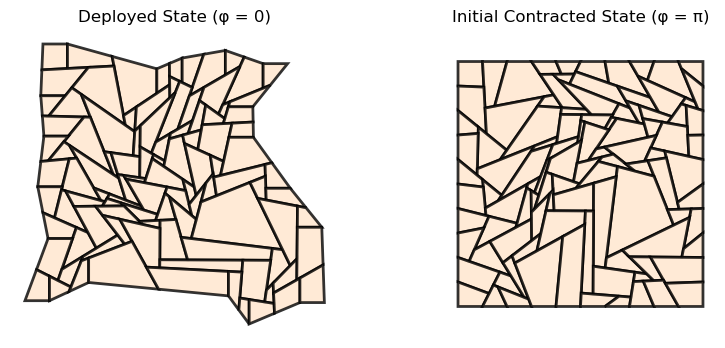

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(1.2*4*2, 4), sharey=True)

deployed_points, deployed_hinge_contact_points = structure.layout(0)
deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - 0)/2.0)

deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

plot_structure(deployed_points, structure.quads, structure.linkages, axs[0])
axs[0].set_aspect('equal')
axs[0].set_title("Deployed State (φ = 0)")

deployed_points, deployed_hinge_contact_points = structure.layout(np.pi)
deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - np.pi)/2.0)

deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

plot_structure(deployed_points, structure.quads, structure.linkages, axs[1])
axs[1].set_aspect('equal')
axs[1].set_title("Initial Contracted State (φ = π)")

In [6]:
result = scopt.least_squares(boundary_residual_circle, np.zeros(width*height),bounds=(-np.ones(width*height),np.inf),xtol = 1e-8,verbose=2)
opt_offsets = np.reshape(result.x, (height, width))

structure.linear_inverse_design(np.vstack(boundary_points), corners, opt_offsets, boundary_offsets)

structure.assign_node_layers()
structure.assign_quad_genders()
structure.make_hinge_contact_points()



   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3377e+01                                    1.93e+00    
       1              2         8.1623e+00      5.22e+00       1.00e+00       1.12e+00    
       2              3         2.5307e+00      5.63e+00       1.97e+00       4.26e-01    
       3              5         1.1473e+00      1.38e+00       9.41e-01       3.80e-01    
       4              6         5.6489e-01      5.82e-01       1.98e+00       4.89e-01    
       5              8         4.4786e-01      1.17e-01       6.89e-01       2.01e+00    
       6              9         4.2043e-01      2.74e-02       1.37e+00       3.71e+00    
       7             10         3.6547e-01      5.50e-02       8.42e-01       7.49e+01    
       8             11         3.5501e-01      1.05e-02       1.71e-01       4.60e+03    
       9             12         3.5421e-01      7.97e-04       2.61e-03       1.50e+05    

Text(0.5, 1.0, 'Initial Contracted State (φ = π)')

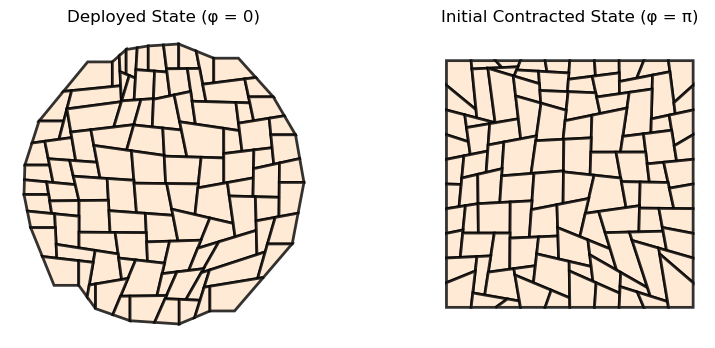

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(1.2*4*2, 4), sharey=True)

deployed_points, deployed_hinge_contact_points = structure.layout(0)
deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - 0)/2.0)

deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

plot_structure(deployed_points, structure.quads, structure.linkages, axs[0])
axs[0].set_aspect('equal')
axs[0].set_title("Deployed State (φ = 0)")

deployed_points, deployed_hinge_contact_points = structure.layout(np.pi)
deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - np.pi)/2.0)

deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

plot_structure(deployed_points, structure.quads, structure.linkages, axs[1])
axs[1].set_aspect('equal')
axs[1].set_title("Initial Contracted State (φ = π)")

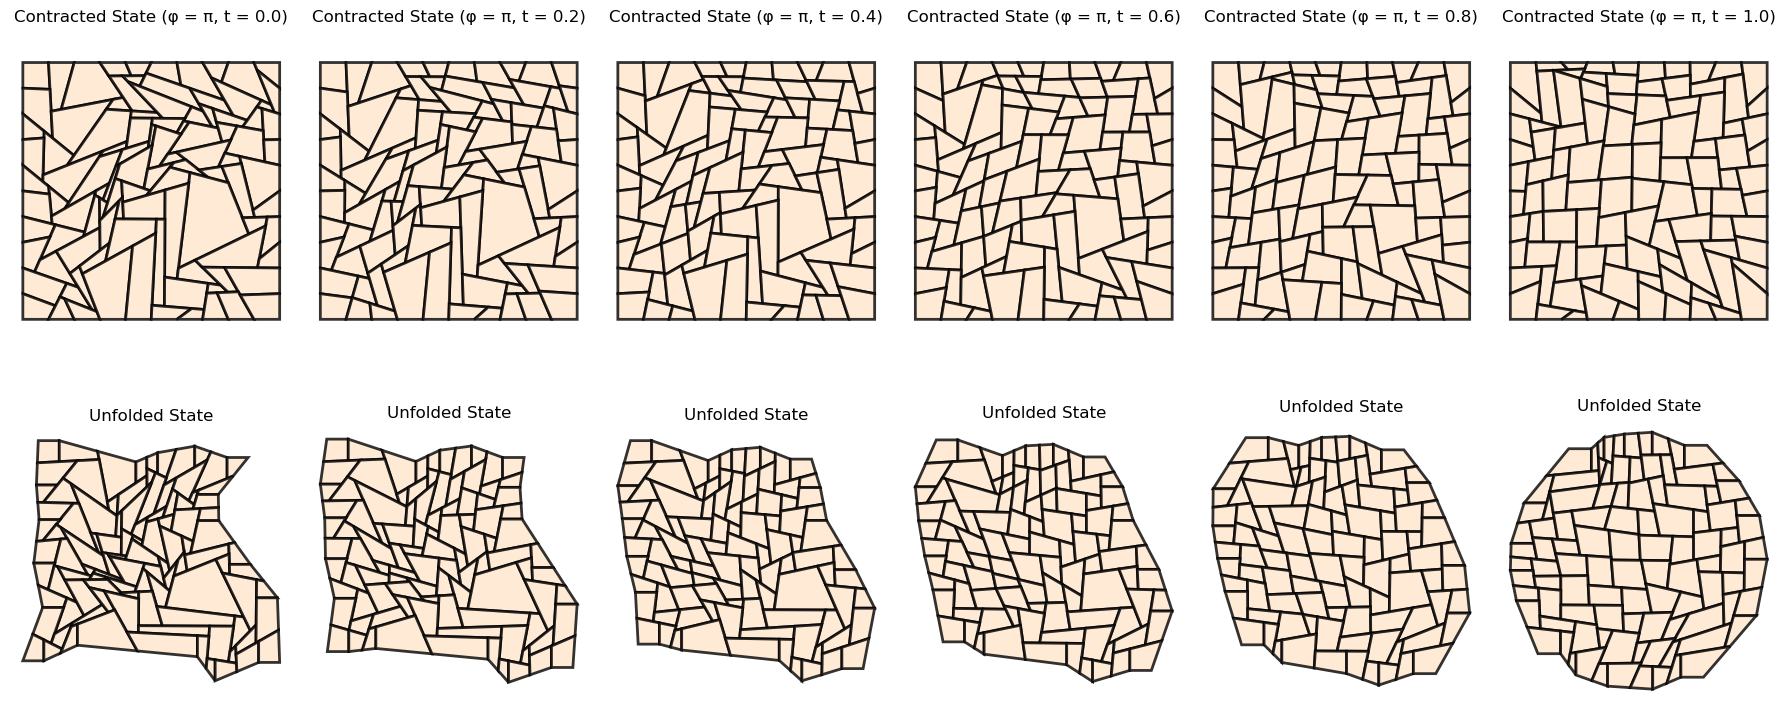

In [8]:
T = np.arange(0, 1+0.2, 0.2)
fig, axs = plt.subplots(2, len(T), figsize=(3*len(T), 8), sharey=True)
for i, t in enumerate(T):
    offset_t = t * opt_offsets + (1-t) * interior_offsets_initial
    structure.linear_inverse_design(np.vstack(boundary_points), corners, offset_t, boundary_offsets)

    deployed_points, deployed_hinge_contact_points = structure.layout(np.pi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - np.pi)/2.0)

    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

    plot_structure(deployed_points, structure.quads, structure.linkages, axs[0, i])
    axs[0, i].set_aspect('equal')
    axs[0, i].set_title(f"Contracted State (φ = π, t = {t:.1f})")

    deployed_points, deployed_hinge_contact_points = structure.layout(0)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - 0)/2.0)

    deployed_points[:,0] = deployed_points[:,0] - (np.max(deployed_points[:,0])+np.min(deployed_points[:,0]))/2
    deployed_points[:,1] = deployed_points[:,1] - (np.max(deployed_points[:,1])+np.min(deployed_points[:,1]))/2

    plot_structure(deployed_points, structure.quads, structure.linkages, axs[1, i])
    axs[1, i].set_aspect('equal')
    axs[1, i].set_title(f"Unfolded State")

# tighten layout
plt.tight_layout()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# --------- helpers ---------
def _center_minmax(P):
    P = P.copy()
    cx = 0.5 * (P[:,0].max() + P[:,0].min())
    cy = 0.5 * (P[:,1].max() + P[:,1].min())
    P[:,0] -= cx
    P[:,1] -= cy
    return P

def _points_for(structure, phi, t, opt_offsets, interior_offsets_initial,
                boundary_points, corners, boundary_offsets):
    # interpolate offsets and solve
    offset_t = t * opt_offsets + (1.0 - t) * interior_offsets_initial
    structure.linear_inverse_design(np.vstack(boundary_points), corners, offset_t, boundary_offsets)

    # layout and smooth rotation so orientation transitions continuously with phi
    deployed_points, _ = structure.layout(phi)
    deployed_points = rotate_points(deployed_points, np.array([0, 0]), -(np.pi - phi)/2.0)

    # recentre like your original code
    deployed_points = _center_minmax(deployed_points)
    return deployed_points

def _compute_bounds(structure, T, phis, opt_offsets, interior_offsets_initial,
                    boundary_points, corners, boundary_offsets, margin=0.05):
    xs_min, xs_max, ys_min, ys_max = [], [], [], []
    for t in T:
        for phi in phis:
            P = _points_for(structure, phi, t, opt_offsets, interior_offsets_initial,
                            boundary_points, corners, boundary_offsets)
            xs_min.append(P[:,0].min()); xs_max.append(P[:,0].max())
            ys_min.append(P[:,1].min()); ys_max.append(P[:,1].max())
    xmin, xmax = float(np.min(xs_min)), float(np.max(xs_max))
    ymin, ymax = float(np.min(ys_min)), float(np.max(ys_max))
    dx, dy = xmax - xmin, ymax - ymin
    xmin -= margin*dx; xmax += margin*dx
    ymin -= margin*dy; ymax += margin*dy
    return xmin, xmax, ymin, ymax

# --------- GIF 1: sweep over t (contracted vs. unfolded) ---------
def make_t_sweep_gif(structure, T,
                     opt_offsets, interior_offsets_initial,
                     boundary_points, corners, boundary_offsets,
                     out_path="flow_sweep_t.gif", dpi=200, fps=2):
    # consistent bounds using phi endpoints
    xmin, xmax, ymin, ymax = _compute_bounds(
        structure, T, [np.pi, 0.0], opt_offsets, interior_offsets_initial,
        boundary_points, corners, boundary_offsets
    )

    fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
    for ax in axes:
        ax.set_aspect('equal')
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
        ax.set_xticks([]); ax.set_yticks([])
        ax.spines[:].set_visible(False)

    suptitle = fig.suptitle("", y=0.98)

    def draw_state(ax, phi, t):
        P = _points_for(structure, phi, t, opt_offsets, interior_offsets_initial,
                        boundary_points, corners, boundary_offsets)
        plot_structure(P, structure.quads, structure.linkages, ax)

    def update(frame_idx):
        t = T[frame_idx % len(T)]
        for ax in axes:
            ax.cla()
            ax.set_aspect('equal')
            ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
            ax.set_xticks([]); ax.set_yticks([]); ax.spines[:].set_visible(False)

        # left: contracted (phi=pi), right: unfolded (phi=0)
        draw_state(axes[0], np.pi, t);   axes[0].set_title("Contracted (ϕ = π)")
        draw_state(axes[1], 0.0,   t);   axes[1].set_title("Unfolded (ϕ = 0)")

        suptitle.set_text(f"Flow-matching sweep   t = {t:.2f}")
        return axes

    anim = FuncAnimation(fig, update, frames=len(T), blit=False)
    anim.save(out_path, writer=PillowWriter(fps=fps), dpi=dpi)
    plt.close(fig)

# --------- GIF 2: all shapes deform (ϕ: π → 0) for every t ---------
def make_deformation_gif(
    structure, T,
    opt_offsets, interior_offsets_initial,
    boundary_points, corners, boundary_offsets,
    N_phi=40, out_path="flow_deformation_all_t.gif", dpi=200, fps=12
):
    phi_values = np.linspace(np.pi, 0.0, N_phi)

    xmin, xmax, ymin, ymax = _compute_bounds(
        structure, T, phi_values, opt_offsets, interior_offsets_initial,
        boundary_points, corners, boundary_offsets
    )

    fig, axes = plt.subplots(1, len(T), figsize=(3*len(T), 3), sharey=True)
    if len(T) == 1:
        axes = [axes]

    for i, ax in enumerate(axes):
        ax.set_aspect('equal')
        ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
        ax.set_xticks([]); ax.set_yticks([]); ax.spines[:].set_visible(False)
        ax.set_title(f"t = {T[i]:.1f}")

    suptitle = fig.suptitle("", y=0.98)

    def update(frame_idx):
        phi = phi_values[frame_idx]
        for i, t in enumerate(T):
            ax = axes[i]
            ax.cla()
            ax.set_aspect('equal')
            ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
            ax.set_xticks([]); ax.set_yticks([]); ax.spines[:].set_visible(False)
            ax.set_title(f"t = {t:.1f}")

            P = _points_for(structure, phi, t, opt_offsets, interior_offsets_initial,
                            boundary_points, corners, boundary_offsets)
            plot_structure(P, structure.quads, structure.linkages, ax)

        suptitle.set_text(f"Deformation across shapes   ϕ = {phi:.2f} rad")
        return axes

    anim = FuncAnimation(fig, update, frames=N_phi, blit=False)
    anim.save(out_path, writer=PillowWriter(fps=fps), dpi=dpi)
    plt.close(fig)
# Choose your T as you like (keeps your original grid density)
T = np.arange(0, 1+0.05, 0.05)
make_t_sweep_gif(structure, T, opt_offsets, interior_offsets_initial,
                 boundary_points, corners, boundary_offsets,
                 out_path="flow_sweep_t.gif", dpi=220, fps=8)
# make_deformation_gif(structure, T, N_phi=48, opt_offsets=opt_offsets,
#                      interior_offsets_initial=interior_offsets_initial,
#                      boundary_points=boundary_points, corners=corners,
#                      boundary_offsets=boundary_offsets,
#                      out_path="flow_deformation_all_t.gif", dpi=220, fps=12)
